## Post #1: Version your Machine Learning models with MLflow

In [53]:
import mlflow
import os
from IPython.display import Image
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import accuracy_score

### Setting up a postgreSQL database to store runs

The first step is to create a conda environment:

We'll start by installing postgresql via conda:

Now create a new PostgreSQL database cluster via initdb , and start de database server

Now we will use `psql` to start a PostgreSQL interactive terminal. 
We can do so by accessing the postgres database, which is already present in the installation:

We need to specify some existing database (postgres for instance) because by default psql will try to connect to a database with the same name as your user, and since it doesn't exist, it will return an error.
Once in the interactive terminal, create a new database for mlflow to store all registered models: 

And lets add a user and password to authenticate when access the database:

To see the current users:

 <img src="./images/mlflow/du.png" />

And we can also check that the database has been correctly created, and can be accesed by the user mlflow .

 <img src="./images/mlflow/list.png" />

If everything looks good, you can now exit the console with:

### Mlflow

Now its time to get started with mlflow. Let's start by pip installing mlflow and psycopg2, a PostgreSQL adapter for Python:

We'll need to create a directory

Now everything is ready to run the MLflow tracking server!

You can now access the MLflow UI in the specified adress http://localhost:8000 

 <img src="./images/mlflow/mlflow_ui.png" />

### Basic logging

Set env vars

In [2]:
os.environ['MLFLOW_TRACKING_URI'] = 'http://localhost:8000/'

/home/aescola/anaconda3/envs/mlflow/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [227]:
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.3)

In [228]:
dt_params = {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split':6}
dt = DecisionTreeClassifier(**dt_params)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
acc = accuracy_score(y_test, y_pred).round(3)

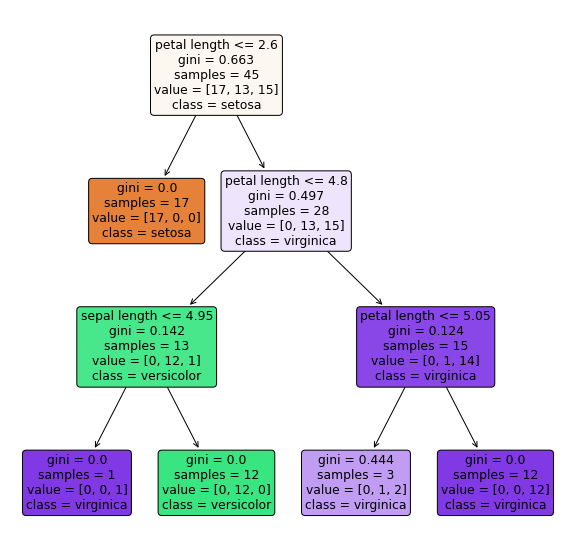

In [230]:
plt.figure(figsize=(10,10))
t = plot_tree(dt,
              feature_names=['sepal length', 'sepal width', 'petal length', 'petal width'],
              class_names=load_iris()['target_names'],
              filled=True,
              label='all',
              rounded=True)
tree_plot_path = "dtree.jpg"
plt.savefig(tree_plot_path)

In [235]:
mlflow.set_experiment('DecisionTreeClassifier')

INFO: 'DecisionTreeClassifier' does not exist. Creating a new experiment


In [238]:
with mlflow.start_run(run_name='basic parameters'):

    mlflow.sklearn.log_model(sk_model=dt,
                             artifact_path='',
                             registered_model_name='tree_model')

    mlflow.log_params(dt_params)
    mlflow.log_metric('Accuracy', acc)
    mlflow.log_artifact(tree_plot_path, artifact_path='plots')

Registered model 'tree_model' already exists. Creating a new version of this model...
2020/12/04 11:41:37 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: tree_model, version 3
Created version '3' of model 'tree_model'.


----

### ## Post #2: Autologging and model serving

In [105]:
import hyperopt as hp
import numpy as np
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [127]:
from sklearn.preprocessing import StandardScaler

In [128]:
X, y = load_iris(return_X_y=True)

In [129]:
X = StandardScaler().fit_transform(X)

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.3)

In [161]:
xgb_params = {
    'objective': 'multi:softmax',
    'num_class':3,
    'eta':              hp.choice('eta',              np.arange(0.05, 0.31, 0.05)),
    'gamma':            hp.quniform('gamma', 0., 1, 0.05),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
}

In [157]:
class HPOpt():

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        result = fmin(fn=getattr(self, fn_name), 
                      space=space, 
                      algo=algo, 
                      max_evals=max_evals)
        return result

    def xgb(self, para):
        # as a result from a grid search over the weight        
        dtrain = xgb.DMatrix(data=self.x_train, 
                             label=self.y_train)
        
        dtest = xgb.DMatrix(data=self.x_test, 
                             label=self.y_test)
                
        reg = xgb.train(params=para, 
                        dtrain=dtrain,
                        evals=[(dtest, 'eval'), (dtrain, 'train')]
                        )
        
        y_pred = reg.predict(dtest)
        score = accuracy_score(self.y_test, y_pred)
        return {'loss': score, 'status': STATUS_OK}

In [158]:
mlflow.set_experiment('Hyperopt+xgoost')

In [162]:
mlflow.xgboost.autolog() 
with mlflow.start_run():
    obj = HPOpt(X_train, X_test, y_train, y_test)
    max_evals = 50
    xgb_opt = obj.process(fn_name='xgb', 
                          space=xgb_params, 
                          algo=tpe.suggest, 
                          trials=Trials(),
                          max_evals=max_evals)

[0]	eval-merror:0.07619	train-merror:0.04444          

[1]	eval-merror:0.07619	train-merror:0.02222          

[2]	eval-merror:0.05714	train-merror:0.02222          

[3]	eval-merror:0.06667	train-merror:0.02222          

[4]	eval-merror:0.07619	train-merror:0.02222          

[5]	eval-merror:0.05714	train-merror:0.02222          

[6]	eval-merror:0.05714	train-merror:0.00000          

[7]	eval-merror:0.05714	train-merror:0.00000          

[8]	eval-merror:0.05714	train-merror:0.00000          

[9]	eval-merror:0.05714	train-merror:0.02222          

[0]	eval-merror:0.07619	train-merror:0.04444                                    

[1]	eval-merror:0.05714	train-merror:0.02222                                    

  2%|▏         | 1/50 [00:01<01:22,  1.68s/trial, best loss: 0.9428571428571428]

/home/aescola/anaconda3/envs/mlflow/lib/python3.8/site-packages/mlflow/xgboost.py:398: UserWarning: Logging to MLflow failed: INVALID_PARAMETER_VALUE: Changing param values is not allowed. Param with key='eta' was already logged with value='0.3' for run ID='7e64b5bb30fa496ba08b2026fa328206'. Attempted logging new value '0.15000000000000002'.
  try_mlflow_log(mlflow.log_params, params)



[2]	eval-merror:0.05714	train-merror:0.02222                                    

[3]	eval-merror:0.05714	train-merror:0.02222                                    

[4]	eval-merror:0.05714	train-merror:0.02222                                    

[5]	eval-merror:0.05714	train-merror:0.02222                                    

[6]	eval-merror:0.05714	train-merror:0.00000                                    

[7]	eval-merror:0.04762	train-merror:0.00000                                    

[8]	eval-merror:0.04762	train-merror:0.00000                                    

[9]	eval-merror:0.04762	train-merror:0.00000                                    

[0]	eval-merror:0.27619	train-merror:0.31111                                    

  4%|▍         | 2/50 [00:03<01:22,  1.71s/trial, best loss: 0.9428571428571428]

/home/aescola/anaconda3/envs/mlflow/lib/python3.8/site-packages/mlflow/xgboost.py:398: UserWarning: Logging to MLflow failed: INVALID_PARAMETER_VALUE: Changing param values is not allowed. Param with key='colsample_bytree' was already logged with value='0.4' for run ID='7e64b5bb30fa496ba08b2026fa328206'. Attempted logging new value '0.7000000000000002'.
  try_mlflow_log(mlflow.log_params, params)



[1]	eval-merror:0.19048	train-merror:0.24444                                    

[2]	eval-merror:0.04762	train-merror:0.06667                                    

[3]	eval-merror:0.04762	train-merror:0.06667                                    

[4]	eval-merror:0.07619	train-merror:0.08889                                    

[5]	eval-merror:0.04762	train-merror:0.06667                                    

[6]	eval-merror:0.04762	train-merror:0.06667                                    

[7]	eval-merror:0.05714	train-merror:0.06667                                    

[8]	eval-merror:0.04762	train-merror:0.06667                                    

[9]	eval-merror:0.04762	train-merror:0.06667                                    

[0]	eval-merror:0.07619	train-merror:0.04444                                    

[1]	eval-merror:0.03809	train-merror:0.02222                                    

[2]	eval-merror:0.03809	train-merror:0.02222                                    

  6%|▌         |

/home/aescola/anaconda3/envs/mlflow/lib/python3.8/site-packages/mlflow/xgboost.py:398: UserWarning: Logging to MLflow failed: INVALID_PARAMETER_VALUE: Changing param values is not allowed. Param with key='colsample_bytree' was already logged with value='0.4' for run ID='7e64b5bb30fa496ba08b2026fa328206'. Attempted logging new value '0.5'.
  try_mlflow_log(mlflow.log_params, params)



[3]	eval-merror:0.03809	train-merror:0.02222                                    

[4]	eval-merror:0.03809	train-merror:0.02222                                    

[5]	eval-merror:0.03809	train-merror:0.02222                                    

[6]	eval-merror:0.05714	train-merror:0.00000                                    

[7]	eval-merror:0.05714	train-merror:0.00000                                    

[8]	eval-merror:0.05714	train-merror:0.00000                                    

[9]	eval-merror:0.05714	train-merror:0.00000                                    

[0]	eval-merror:0.07619	train-merror:0.04444                                    

[1]	eval-merror:0.06667	train-merror:0.02222                                    

[2]	eval-merror:0.05714	train-merror:0.02222                                    

[3]	eval-merror:0.05714	train-merror:0.02222                                    

[4]	eval-merror:0.04762	train-merror:0.02222                                    

[5]	eval-merror:

/home/aescola/anaconda3/envs/mlflow/lib/python3.8/site-packages/mlflow/xgboost.py:398: UserWarning: Logging to MLflow failed: INVALID_PARAMETER_VALUE: Changing param values is not allowed. Param with key='gamma' was already logged with value='0.1' for run ID='7e64b5bb30fa496ba08b2026fa328206'. Attempted logging new value '0.9500000000000001'.
  try_mlflow_log(mlflow.log_params, params)



[8]	eval-merror:0.05714	train-merror:0.00000                                    

[9]	eval-merror:0.05714	train-merror:0.02222                                    

[0]	eval-merror:0.07619	train-merror:0.04444                                    

[1]	eval-merror:0.05714	train-merror:0.02222                                    

[2]	eval-merror:0.04762	train-merror:0.02222                                    

[3]	eval-merror:0.03809	train-merror:0.02222                                    

[4]	eval-merror:0.02857	train-merror:0.02222                                    

[5]	eval-merror:0.02857	train-merror:0.02222                                    

[6]	eval-merror:0.05714	train-merror:0.00000                                    

[7]	eval-merror:0.05714	train-merror:0.00000                                    

[8]	eval-merror:0.05714	train-merror:0.00000                                    

[9]	eval-merror:0.05714	train-merror:0.00000                                    

[0]	eval-merror:

/home/aescola/anaconda3/envs/mlflow/lib/python3.8/site-packages/mlflow/xgboost.py:398: UserWarning: Logging to MLflow failed: INVALID_PARAMETER_VALUE: Changing param values is not allowed. Param with key='colsample_bytree' was already logged with value='0.4' for run ID='7e64b5bb30fa496ba08b2026fa328206'. Attempted logging new value '0.3'.
  try_mlflow_log(mlflow.log_params, params)



[1]	eval-merror:0.12381	train-merror:0.13333                                    

[2]	eval-merror:0.09524	train-merror:0.08889                                    

[3]	eval-merror:0.06667	train-merror:0.04444                                    

[4]	eval-merror:0.05714	train-merror:0.04444                                    

[5]	eval-merror:0.05714	train-merror:0.04444                                    

[6]	eval-merror:0.04762	train-merror:0.00000                                    

[7]	eval-merror:0.04762	train-merror:0.02222                                    

[8]	eval-merror:0.04762	train-merror:0.02222                                    

[9]	eval-merror:0.03809	train-merror:0.02222                                    

[0]	eval-merror:0.27619	train-merror:0.31111                                    

[1]	eval-merror:0.21905	train-merror:0.31111                                    

[2]	eval-merror:0.08571	train-merror:0.11111                                    

[3]	eval-merror:

/home/aescola/anaconda3/envs/mlflow/lib/python3.8/site-packages/mlflow/xgboost.py:398: UserWarning: Logging to MLflow failed: INVALID_PARAMETER_VALUE: Changing param values is not allowed. Param with key='colsample_bytree' was already logged with value='0.4' for run ID='7e64b5bb30fa496ba08b2026fa328206'. Attempted logging new value '0.6000000000000001'.
  try_mlflow_log(mlflow.log_params, params)



[5]	eval-merror:0.07619	train-merror:0.11111                                    

[6]	eval-merror:0.05714	train-merror:0.08889                                    

[7]	eval-merror:0.04762	train-merror:0.06667                                    

[8]	eval-merror:0.04762	train-merror:0.00000                                    

[9]	eval-merror:0.07619	train-merror:0.06667                                    

[0]	eval-merror:0.08571	train-merror:0.02222                                    

[1]	eval-merror:0.03809	train-merror:0.02222                                    

[2]	eval-merror:0.03809	train-merror:0.02222                                    

[3]	eval-merror:0.03809	train-merror:0.02222                                    

[4]	eval-merror:0.03809	train-merror:0.02222                                    

[5]	eval-merror:0.03809	train-merror:0.02222                                    

[6]	eval-merror:0.04762	train-merror:0.00000                                    

[7]	eval-merror:

2020/12/03 11:06:15 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


[0]	eval-merror:0.05714	train-merror:0.02222                                     

[1]	eval-merror:0.05714	train-merror:0.02222                                     

[2]	eval-merror:0.04762	train-merror:0.02222                                     

[3]	eval-merror:0.04762	train-merror:0.02222                                     

[4]	eval-merror:0.04762	train-merror:0.02222                                     

[5]	eval-merror:0.03809	train-merror:0.02222                                     

[6]	eval-merror:0.04762	train-merror:0.02222                                     

[7]	eval-merror:0.04762	train-merror:0.02222                                     

[8]	eval-merror:0.05714	train-merror:0.00000                                     

[9]	eval-merror:0.05714	train-merror:0.00000                                     

 22%|██▏       | 11/50 [00:16<00:49,  1.26s/trial, best loss: 0.9238095238095239]

2020/12/03 11:06:17 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


[0]	eval-merror:0.51429	train-merror:0.48889                                     

[1]	eval-merror:0.35238	train-merror:0.40000                                     

[2]	eval-merror:0.32381	train-merror:0.37778                                     

[3]	eval-merror:0.30476	train-merror:0.31111                                     

[4]	eval-merror:0.31429	train-merror:0.31111                                     

[5]	eval-merror:0.27619	train-merror:0.31111                                     

[6]	eval-merror:0.25714	train-merror:0.31111                                     

[7]	eval-merror:0.24762	train-merror:0.31111                                     

[8]	eval-merror:0.22857	train-merror:0.28889                                     

[9]	eval-merror:0.19048	train-merror:0.26667                                     

 24%|██▍       | 12/50 [00:19<00:59,  1.55s/trial, best loss: 0.9238095238095239]

2020/12/03 11:06:19 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


[0]	eval-merror:0.09524	train-merror:0.00000                                     

[1]	eval-merror:0.05714	train-merror:0.02222                                     

[2]	eval-merror:0.05714	train-merror:0.02222                                     

[3]	eval-merror:0.04762	train-merror:0.02222                                     

[4]	eval-merror:0.04762	train-merror:0.00000                                     

[5]	eval-merror:0.03809	train-merror:0.00000                                     

[6]	eval-merror:0.04762	train-merror:0.00000                                     

[7]	eval-merror:0.04762	train-merror:0.00000                                     

[8]	eval-merror:0.05714	train-merror:0.00000                                     

[9]	eval-merror:0.05714	train-merror:0.00000                                     

 26%|██▌       | 13/50 [00:22<01:05,  1.78s/trial, best loss: 0.8095238095238095]

2020/12/03 11:06:23 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


 28%|██▊       | 14/50 [00:23<01:22,  2.30s/trial, best loss: 0.8095238095238095]

/home/aescola/anaconda3/envs/mlflow/lib/python3.8/site-packages/mlflow/xgboost.py:398: UserWarning: Logging to MLflow failed: INVALID_PARAMETER_VALUE: Changing param values is not allowed. Param with key='gamma' was already logged with value='0.1' for run ID='7e64b5bb30fa496ba08b2026fa328206'. Attempted logging new value '0.65'.
  try_mlflow_log(mlflow.log_params, params)



[0]	eval-merror:0.07619	train-merror:0.04444                                     

[1]	eval-merror:0.06667	train-merror:0.02222                                     

[2]	eval-merror:0.05714	train-merror:0.02222                                     

[3]	eval-merror:0.05714	train-merror:0.02222                                     

[4]	eval-merror:0.04762	train-merror:0.02222                                     

[5]	eval-merror:0.06667	train-merror:0.02222                                     

[6]	eval-merror:0.05714	train-merror:0.00000                                     

[7]	eval-merror:0.05714	train-merror:0.00000                                     

[8]	eval-merror:0.05714	train-merror:0.00000                                     

[9]	eval-merror:0.05714	train-merror:0.00000                                     

 28%|██▊       | 14/50 [00:24<01:22,  2.30s/trial, best loss: 0.8095238095238095]

2020/12/03 11:06:24 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


[0]	eval-merror:0.07619	train-merror:0.04444                                     

[1]	eval-merror:0.05714	train-merror:0.00000                                     

[2]	eval-merror:0.05714	train-merror:0.02222                                     

[3]	eval-merror:0.05714	train-merror:0.02222                                     

[4]	eval-merror:0.05714	train-merror:0.02222                                     

[5]	eval-merror:0.05714	train-merror:0.02222                                     

[6]	eval-merror:0.05714	train-merror:0.00000                                     

[7]	eval-merror:0.05714	train-merror:0.00000                                     

[8]	eval-merror:0.05714	train-merror:0.00000                                     

[9]	eval-merror:0.05714	train-merror:0.00000                                     

 30%|███       | 15/50 [00:25<01:10,  2.00s/trial, best loss: 0.8095238095238095]

2020/12/03 11:06:25 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


[0]	eval-merror:0.42857	train-merror:0.42222                                     

[1]	eval-merror:0.18095	train-merror:0.20000                                     

[2]	eval-merror:0.09524	train-merror:0.06667                                     

[3]	eval-merror:0.09524	train-merror:0.06667                                     

[4]	eval-merror:0.15238	train-merror:0.20000                                     

[5]	eval-merror:0.15238	train-merror:0.20000                                     

[6]	eval-merror:0.05714	train-merror:0.00000                                     

[7]	eval-merror:0.05714	train-merror:0.00000                                     

[8]	eval-merror:0.04762	train-merror:0.02222                                     

[9]	eval-merror:0.03809	train-merror:0.04444                                     

 32%|███▏      | 16/50 [00:26<00:58,  1.71s/trial, best loss: 0.8095238095238095]

2020/12/03 11:06:26 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


[0]	eval-merror:0.09524	train-merror:0.02222                                     

[1]	eval-merror:0.03809	train-merror:0.02222                                     

[2]	eval-merror:0.03809	train-merror:0.02222                                     

[3]	eval-merror:0.03809	train-merror:0.02222                                     

[4]	eval-merror:0.03809	train-merror:0.02222                                     

[5]	eval-merror:0.03809	train-merror:0.02222                                     

[6]	eval-merror:0.05714	train-merror:0.00000                                     

[7]	eval-merror:0.05714	train-merror:0.00000                                     

[8]	eval-merror:0.05714	train-merror:0.00000                                     

[9]	eval-merror:0.05714	train-merror:0.00000                                     

 34%|███▍      | 17/50 [00:27<00:51,  1.56s/trial, best loss: 0.8095238095238095]

2020/12/03 11:06:28 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


[0]	eval-merror:0.09524	train-merror:0.02222                                     

[1]	eval-merror:0.03809	train-merror:0.02222                                     

[2]	eval-merror:0.03809	train-merror:0.02222                                     

[3]	eval-merror:0.03809	train-merror:0.02222                                     

[4]	eval-merror:0.03809	train-merror:0.02222                                     

[5]	eval-merror:0.02857	train-merror:0.02222                                     

[6]	eval-merror:0.05714	train-merror:0.00000                                     

[7]	eval-merror:0.05714	train-merror:0.00000                                     

[8]	eval-merror:0.05714	train-merror:0.00000                                     

[9]	eval-merror:0.05714	train-merror:0.00000                                     

 36%|███▌      | 18/50 [00:28<00:46,  1.44s/trial, best loss: 0.8095238095238095]

2020/12/03 11:06:29 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


[0]	eval-merror:0.09524	train-merror:0.02222                                     

[1]	eval-merror:0.05714	train-merror:0.04444                                     

[2]	eval-merror:0.04762	train-merror:0.02222                                     

[3]	eval-merror:0.04762	train-merror:0.02222                                     

[4]	eval-merror:0.04762	train-merror:0.02222                                     

[5]	eval-merror:0.03809	train-merror:0.02222                                     

[6]	eval-merror:0.05714	train-merror:0.00000                                     

[7]	eval-merror:0.05714	train-merror:0.00000                                     

[8]	eval-merror:0.05714	train-merror:0.00000                                     

[9]	eval-merror:0.05714	train-merror:0.00000                                     

 38%|███▊      | 19/50 [00:29<00:40,  1.32s/trial, best loss: 0.8095238095238095]

2020/12/03 11:06:30 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


[0]	eval-merror:0.27619	train-merror:0.31111                                     

[1]	eval-merror:0.25714	train-merror:0.31111                                     

[2]	eval-merror:0.15238	train-merror:0.22222                                     

[3]	eval-merror:0.15238	train-merror:0.22222                                     

[4]	eval-merror:0.20952	train-merror:0.26667                                     

[5]	eval-merror:0.12381	train-merror:0.17778                                     

[6]	eval-merror:0.11429	train-merror:0.13333                                     

[7]	eval-merror:0.09524	train-merror:0.13333                                     

[8]	eval-merror:0.08571	train-merror:0.13333                                     

[9]	eval-merror:0.08571	train-merror:0.13333                                     

 40%|████      | 20/50 [00:30<00:38,  1.27s/trial, best loss: 0.8095238095238095]

2020/12/03 11:06:31 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


[0]	eval-merror:0.27619	train-merror:0.31111                                     

[1]	eval-merror:0.25714	train-merror:0.31111                                     

[2]	eval-merror:0.15238	train-merror:0.22222                                     

[3]	eval-merror:0.15238	train-merror:0.22222                                     

[4]	eval-merror:0.20952	train-merror:0.26667                                     

[5]	eval-merror:0.12381	train-merror:0.17778                                     

[6]	eval-merror:0.11429	train-merror:0.13333                                     

[7]	eval-merror:0.09524	train-merror:0.13333                                     

[8]	eval-merror:0.08571	train-merror:0.13333                                     

[9]	eval-merror:0.08571	train-merror:0.13333                                     

 42%|████▏     | 21/50 [00:31<00:36,  1.27s/trial, best loss: 0.8095238095238095]

2020/12/03 11:06:32 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


[0]	eval-merror:0.51429	train-merror:0.48889                                     

[1]	eval-merror:0.34286	train-merror:0.33333                                     

[2]	eval-merror:0.32381	train-merror:0.37778                                     

[3]	eval-merror:0.33333	train-merror:0.37778                                     

[4]	eval-merror:0.35238	train-merror:0.37778                                     

[5]	eval-merror:0.30476	train-merror:0.37778                                     

[6]	eval-merror:0.27619	train-merror:0.35556                                     

[7]	eval-merror:0.23810	train-merror:0.26667                                     

[8]	eval-merror:0.23810	train-merror:0.26667                                     

[9]	eval-merror:0.19048	train-merror:0.24444                                     

 44%|████▍     | 22/50 [00:32<00:32,  1.17s/trial, best loss: 0.8095238095238095]

2020/12/03 11:06:33 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


[0]	eval-merror:0.51429	train-merror:0.48889                                     

[1]	eval-merror:0.34286	train-merror:0.33333                                     

[2]	eval-merror:0.31429	train-merror:0.35556                                     

[3]	eval-merror:0.29524	train-merror:0.37778                                     

[4]	eval-merror:0.29524	train-merror:0.33333                                     

[5]	eval-merror:0.27619	train-merror:0.33333                                     

[6]	eval-merror:0.25714	train-merror:0.26667                                     

[7]	eval-merror:0.23810	train-merror:0.26667                                     

[8]	eval-merror:0.21905	train-merror:0.26667                                     

[9]	eval-merror:0.20000	train-merror:0.20000                                     

 46%|████▌     | 23/50 [00:33<00:29,  1.11s/trial, best loss: 0.8095238095238095]

2020/12/03 11:06:34 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


[0]	eval-merror:0.24762	train-merror:0.37778                                     

[1]	eval-merror:0.22857	train-merror:0.26667                      

[2]	eval-merror:0.09524	train-merror:0.15556                      

[3]	eval-merror:0.09524	train-merror:0.11111                      

[4]	eval-merror:0.09524	train-merror:0.11111                      

[5]	eval-merror:0.06667	train-merror:0.06667                      

[6]	eval-merror:0.05714	train-merror:0.06667                      

[7]	eval-merror:0.04762	train-merror:0.06667                      

[8]	eval-merror:0.04762	train-merror:0.06667                      

[9]	eval-merror:0.04762	train-merror:0.06667                      

 48%|████▊     | 24/50 [00:35<00:28,  1.10s/trial, best loss: 0.8]

2020/12/03 11:06:35 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


[0]	eval-merror:0.47619	train-merror:0.46667                      

[1]	eval-merror:0.28571	train-merror:0.31111                      

[2]	eval-merror:0.18095	train-merror:0.24444                      

[3]	eval-merror:0.17143	train-merror:0.24444                      

[4]	eval-merror:0.19048	train-merror:0.26667                      

[5]	eval-merror:0.14286	train-merror:0.17778                      

[6]	eval-merror:0.13333	train-merror:0.17778                      

[7]	eval-merror:0.12381	train-merror:0.15556                      

[8]	eval-merror:0.12381	train-merror:0.15556                      

[9]	eval-merror:0.11429	train-merror:0.13333                      

 50%|█████     | 25/50 [00:36<00:27,  1.10s/trial, best loss: 0.8]

2020/12/03 11:06:36 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


[0]	eval-merror:0.47619	train-merror:0.46667                      

[1]	eval-merror:0.26667	train-merror:0.28889                      

[2]	eval-merror:0.25714	train-merror:0.31111                      

[3]	eval-merror:0.25714	train-merror:0.35556                      

[4]	eval-merror:0.26667	train-merror:0.33333                      

[5]	eval-merror:0.23810	train-merror:0.26667                      

[6]	eval-merror:0.21905	train-merror:0.28889                      

[7]	eval-merror:0.21905	train-merror:0.28889                      

[8]	eval-merror:0.21905	train-merror:0.28889                      

[9]	eval-merror:0.16190	train-merror:0.22222                      

 52%|█████▏    | 26/50 [00:37<00:26,  1.09s/trial, best loss: 0.8]

2020/12/03 11:06:37 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


[0]	eval-merror:0.40000	train-merror:0.42222                      

[1]	eval-merror:0.20000	train-merror:0.26667                      

[2]	eval-merror:0.07619	train-merror:0.11111                      

[3]	eval-merror:0.08571	train-merror:0.11111                      

[4]	eval-merror:0.06667	train-merror:0.02222                      

[5]	eval-merror:0.05714	train-merror:0.06667                      

[6]	eval-merror:0.05714	train-merror:0.02222                      

[7]	eval-merror:0.05714	train-merror:0.02222                      

[8]	eval-merror:0.05714	train-merror:0.00000                      

[9]	eval-merror:0.04762	train-merror:0.02222                      

 54%|█████▍    | 27/50 [00:38<00:25,  1.09s/trial, best loss: 0.8]

2020/12/03 11:06:38 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


[0]	eval-merror:0.40000	train-merror:0.42222                      

[1]	eval-merror:0.20000	train-merror:0.26667                      

[2]	eval-merror:0.07619	train-merror:0.11111                      

[3]	eval-merror:0.08571	train-merror:0.11111                      

[4]	eval-merror:0.06667	train-merror:0.02222                      

[5]	eval-merror:0.05714	train-merror:0.06667                      

[6]	eval-merror:0.05714	train-merror:0.02222                      

[7]	eval-merror:0.05714	train-merror:0.02222                      

[8]	eval-merror:0.05714	train-merror:0.00000                      

[9]	eval-merror:0.05714	train-merror:0.00000                      

 56%|█████▌    | 28/50 [00:39<00:24,  1.10s/trial, best loss: 0.8]

2020/12/03 11:06:40 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


[0]	eval-merror:0.47619	train-merror:0.46667                      

[1]	eval-merror:0.28571	train-merror:0.31111                      

[2]	eval-merror:0.17143	train-merror:0.22222                      

[3]	eval-merror:0.15238	train-merror:0.20000                      

[4]	eval-merror:0.19048	train-merror:0.26667                      

[5]	eval-merror:0.15238	train-merror:0.17778                      

[6]	eval-merror:0.15238	train-merror:0.17778                      

[7]	eval-merror:0.13333	train-merror:0.15556                      

[8]	eval-merror:0.13333	train-merror:0.15556                      

[9]	eval-merror:0.11429	train-merror:0.13333                      

 58%|█████▊    | 29/50 [00:40<00:23,  1.14s/trial, best loss: 0.8]

2020/12/03 11:06:41 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


[0]	eval-merror:0.43810	train-merror:0.46667                      

[1]	eval-merror:0.27619	train-merror:0.33333                      

[2]	eval-merror:0.16190	train-merror:0.24444                      

[3]	eval-merror:0.20952	train-merror:0.31111                      

[4]	eval-merror:0.23810	train-merror:0.31111                      

[5]	eval-merror:0.20000	train-merror:0.24444                      

[6]	eval-merror:0.19048	train-merror:0.24444                      

[7]	eval-merror:0.14286	train-merror:0.20000                      

[8]	eval-merror:0.13333	train-merror:0.20000                      

[9]	eval-merror:0.11429	train-merror:0.17778                      

 60%|██████    | 30/50 [00:41<00:23,  1.18s/trial, best loss: 0.8]

2020/12/03 11:06:42 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


[0]	eval-merror:0.24762	train-merror:0.37778                      

[1]	eval-merror:0.22857	train-merror:0.26667                      

[2]	eval-merror:0.08571	train-merror:0.15556                      

[3]	eval-merror:0.08571	train-merror:0.11111                      

[4]	eval-merror:0.12381	train-merror:0.20000                      

[5]	eval-merror:0.08571	train-merror:0.11111                      

[6]	eval-merror:0.05714	train-merror:0.06667                      

[7]	eval-merror:0.04762	train-merror:0.06667                      

[8]	eval-merror:0.04762	train-merror:0.06667                      

[9]	eval-merror:0.04762	train-merror:0.06667                      

 62%|██████▏   | 31/50 [00:42<00:21,  1.11s/trial, best loss: 0.8]

2020/12/03 11:06:43 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


[0]	eval-merror:0.13333	train-merror:0.13333                      

[1]	eval-merror:0.07619	train-merror:0.08889                      

[2]	eval-merror:0.03809	train-merror:0.02222                      

[3]	eval-merror:0.03809	train-merror:0.04444                      

[4]	eval-merror:0.03809	train-merror:0.02222                      

[5]	eval-merror:0.03809	train-merror:0.02222                      

[6]	eval-merror:0.04762	train-merror:0.02222                      

[7]	eval-merror:0.04762	train-merror:0.02222                      

[8]	eval-merror:0.05714	train-merror:0.00000                      

[9]	eval-merror:0.05714	train-merror:0.02222                      

 64%|██████▍   | 32/50 [00:44<00:19,  1.11s/trial, best loss: 0.8]

2020/12/03 11:06:44 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


 66%|██████▌   | 33/50 [00:44<00:19,  1.14s/trial, best loss: 0.8]

/home/aescola/anaconda3/envs/mlflow/lib/python3.8/site-packages/mlflow/xgboost.py:398: UserWarning: Logging to MLflow failed: INVALID_PARAMETER_VALUE: Changing param values is not allowed. Param with key='eta' was already logged with value='0.3' for run ID='7e64b5bb30fa496ba08b2026fa328206'. Attempted logging new value '0.25'.
  try_mlflow_log(mlflow.log_params, params)



[0]	eval-merror:0.42857	train-merror:0.42222                      

[1]	eval-merror:0.17143	train-merror:0.20000                      

[2]	eval-merror:0.07619	train-merror:0.02222                      

[3]	eval-merror:0.11429	train-merror:0.13333                      

[4]	eval-merror:0.06667	train-merror:0.11111                      

[5]	eval-merror:0.06667	train-merror:0.04444                      

[6]	eval-merror:0.05714	train-merror:0.00000                      

[7]	eval-merror:0.05714	train-merror:0.02222                      

[8]	eval-merror:0.04762	train-merror:0.02222                      

[9]	eval-merror:0.05714	train-merror:0.04444                      

 66%|██████▌   | 33/50 [00:45<00:19,  1.14s/trial, best loss: 0.8]

2020/12/03 11:06:45 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


[0]	eval-merror:0.43810	train-merror:0.46667                      

[1]	eval-merror:0.24762	train-merror:0.28889                      

[2]	eval-merror:0.16190	train-merror:0.24444                      

[3]	eval-merror:0.17143	train-merror:0.24444                      

[4]	eval-merror:0.20000	train-merror:0.26667                      

[5]	eval-merror:0.17143	train-merror:0.24444                      

[6]	eval-merror:0.14286	train-merror:0.17778                      

[7]	eval-merror:0.14286	train-merror:0.17778                      

[8]	eval-merror:0.14286	train-merror:0.17778                      

[9]	eval-merror:0.12381	train-merror:0.13333                      

 68%|██████▊   | 34/50 [00:46<00:18,  1.18s/trial, best loss: 0.8]

2020/12/03 11:06:47 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


[0]	eval-merror:0.07619	train-merror:0.04444                      

[1]	eval-merror:0.03809	train-merror:0.02222                      

[2]	eval-merror:0.03809	train-merror:0.02222                      

[3]	eval-merror:0.03809	train-merror:0.02222                      

[4]	eval-merror:0.04762	train-merror:0.02222                      

[5]	eval-merror:0.04762	train-merror:0.02222                      

[6]	eval-merror:0.05714	train-merror:0.00000                      

[7]	eval-merror:0.05714	train-merror:0.00000                      

[8]	eval-merror:0.05714	train-merror:0.00000                      

[9]	eval-merror:0.05714	train-merror:0.00000                      

 70%|███████   | 35/50 [00:47<00:17,  1.18s/trial, best loss: 0.8]

2020/12/03 11:06:48 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


[0]	eval-merror:0.51429	train-merror:0.48889                      

[1]	eval-merror:0.35238	train-merror:0.40000                      

[2]	eval-merror:0.31429	train-merror:0.31111                      

[3]	eval-merror:0.27619	train-merror:0.33333                      

[4]	eval-merror:0.28571	train-merror:0.31111                      

[5]	eval-merror:0.28571	train-merror:0.31111                      

[6]	eval-merror:0.23810	train-merror:0.28889                      

[7]	eval-merror:0.21905	train-merror:0.28889                      

[8]	eval-merror:0.21905	train-merror:0.26667                      

[9]	eval-merror:0.16190	train-merror:0.22222                      

 72%|███████▏  | 36/50 [00:48<00:15,  1.11s/trial, best loss: 0.8]

2020/12/03 11:06:49 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


[0]	eval-merror:0.51429	train-merror:0.48889                      

[1]	eval-merror:0.34286	train-merror:0.33333                      

[2]	eval-merror:0.31429	train-merror:0.33333                      

[3]	eval-merror:0.28571	train-merror:0.31111                      

[4]	eval-merror:0.28571	train-merror:0.31111                      

[5]	eval-merror:0.28571	train-merror:0.31111                      

[6]	eval-merror:0.26667	train-merror:0.31111                      

[7]	eval-merror:0.24762	train-merror:0.31111                      

[8]	eval-merror:0.22857	train-merror:0.26667                      

[9]	eval-merror:0.20952	train-merror:0.24444                      

 74%|███████▍  | 37/50 [00:49<00:14,  1.12s/trial, best loss: 0.8]

2020/12/03 11:06:50 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


[0]	eval-merror:0.29524	train-merror:0.22222                                     

[1]	eval-merror:0.12381	train-merror:0.13333                                     

 76%|███████▌  | 38/50 [00:50<00:13,  1.09s/trial, best loss: 0.7904761904761904]

/home/aescola/anaconda3/envs/mlflow/lib/python3.8/site-packages/mlflow/xgboost.py:398: UserWarning: Logging to MLflow failed: INVALID_PARAMETER_VALUE: Changing param values is not allowed. Param with key='eta' was already logged with value='0.3' for run ID='7e64b5bb30fa496ba08b2026fa328206'. Attempted logging new value '0.2'.
  try_mlflow_log(mlflow.log_params, params)



[2]	eval-merror:0.09524	train-merror:0.08889                                     

[3]	eval-merror:0.06667	train-merror:0.04444                                     

[4]	eval-merror:0.05714	train-merror:0.04444                                     

[5]	eval-merror:0.05714	train-merror:0.04444                                     

[6]	eval-merror:0.04762	train-merror:0.00000                                     

[7]	eval-merror:0.04762	train-merror:0.02222                                     

[8]	eval-merror:0.04762	train-merror:0.00000                                     

[9]	eval-merror:0.03809	train-merror:0.02222                                     

 76%|███████▌  | 38/50 [00:50<00:13,  1.09s/trial, best loss: 0.7904761904761904]

2020/12/03 11:06:51 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


[0]	eval-merror:0.08571	train-merror:0.06667                                     

[1]	eval-merror:0.05714	train-merror:0.02222                                     

[2]	eval-merror:0.05714	train-merror:0.02222                                     

[3]	eval-merror:0.04762	train-merror:0.02222                                     

[4]	eval-merror:0.05714	train-merror:0.02222                                     

[5]	eval-merror:0.05714	train-merror:0.02222                                     

[6]	eval-merror:0.05714	train-merror:0.02222                                     

[7]	eval-merror:0.05714	train-merror:0.02222                                     

[8]	eval-merror:0.05714	train-merror:0.00000                                     

[9]	eval-merror:0.05714	train-merror:0.00000                                     

 78%|███████▊  | 39/50 [00:51<00:11,  1.09s/trial, best loss: 0.7904761904761904]

2020/12/03 11:06:52 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


[0]	eval-merror:0.43810	train-merror:0.46667                                     

[1]	eval-merror:0.23810	train-merror:0.35556                                     

[2]	eval-merror:0.27619	train-merror:0.35556                                     

[3]	eval-merror:0.25714	train-merror:0.33333                                     

[4]	eval-merror:0.25714	train-merror:0.33333                                     

[5]	eval-merror:0.21905	train-merror:0.31111                                     

[6]	eval-merror:0.20952	train-merror:0.28889                                     

[7]	eval-merror:0.21905	train-merror:0.26667                                     

[8]	eval-merror:0.16190	train-merror:0.17778                                     

[9]	eval-merror:0.13333	train-merror:0.17778                                     

 80%|████████  | 40/50 [00:52<00:10,  1.06s/trial, best loss: 0.7904761904761904]

2020/12/03 11:06:53 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


[0]	eval-merror:0.43810	train-merror:0.46667                                     

[1]	eval-merror:0.21905	train-merror:0.28889                                     

[2]	eval-merror:0.19048	train-merror:0.22222                                     

[3]	eval-merror:0.20000	train-merror:0.26667                                     

[4]	eval-merror:0.20952	train-merror:0.26667                                     

[5]	eval-merror:0.20952	train-merror:0.24444                                     

[6]	eval-merror:0.11429	train-merror:0.13333                                     

[7]	eval-merror:0.04762	train-merror:0.06667                                     

[8]	eval-merror:0.04762	train-merror:0.06667                                     

[9]	eval-merror:0.04762	train-merror:0.06667                                     

 82%|████████▏ | 41/50 [00:53<00:09,  1.11s/trial, best loss: 0.7904761904761904]

2020/12/03 11:06:54 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


[0]	eval-merror:0.40000	train-merror:0.42222                                     

[1]	eval-merror:0.09524	train-merror:0.15556                                     

[2]	eval-merror:0.03809	train-merror:0.02222                                     

[3]	eval-merror:0.04762	train-merror:0.06667                                     

[4]	eval-merror:0.04762	train-merror:0.06667                                     

[5]	eval-merror:0.04762	train-merror:0.06667                                     

[6]	eval-merror:0.03809	train-merror:0.02222                                     

[7]	eval-merror:0.03809	train-merror:0.02222                                     

[8]	eval-merror:0.04762	train-merror:0.02222                                     

[9]	eval-merror:0.04762	train-merror:0.02222                                     

 84%|████████▍ | 42/50 [00:54<00:08,  1.06s/trial, best loss: 0.7904761904761904]

2020/12/03 11:06:55 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


[0]	eval-merror:0.43810	train-merror:0.46667                                     

[1]	eval-merror:0.25714	train-merror:0.31111                                     

[2]	eval-merror:0.27619	train-merror:0.33333                                     

[3]	eval-merror:0.25714	train-merror:0.31111                                     

[4]	eval-merror:0.23810	train-merror:0.31111                                     

[5]	eval-merror:0.22857	train-merror:0.26667                                     

[6]	eval-merror:0.18095	train-merror:0.26667                                     

[7]	eval-merror:0.14286	train-merror:0.17778                                     

[8]	eval-merror:0.14286	train-merror:0.17778                                     

[9]	eval-merror:0.09524	train-merror:0.15556                                     

 86%|████████▌ | 43/50 [00:56<00:07,  1.06s/trial, best loss: 0.7904761904761904]

2020/12/03 11:06:56 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


[0]	eval-merror:0.07619	train-merror:0.04444                                     

[1]	eval-merror:0.07619	train-merror:0.02222                                     

[2]	eval-merror:0.05714	train-merror:0.02222                                     

[3]	eval-merror:0.08571	train-merror:0.02222                                     

[4]	eval-merror:0.06667	train-merror:0.02222                                     

[5]	eval-merror:0.06667	train-merror:0.02222                                     

[6]	eval-merror:0.05714	train-merror:0.00000                                     

[7]	eval-merror:0.05714	train-merror:0.00000                                     

[8]	eval-merror:0.05714	train-merror:0.00000                                     

[9]	eval-merror:0.05714	train-merror:0.00000                                     

 88%|████████▊ | 44/50 [00:57<00:06,  1.09s/trial, best loss: 0.7904761904761904]

2020/12/03 11:06:57 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


[0]	eval-merror:0.07619	train-merror:0.04444                                     

[1]	eval-merror:0.06667	train-merror:0.02222                                     

[2]	eval-merror:0.05714	train-merror:0.02222                                     

[3]	eval-merror:0.05714	train-merror:0.02222                                     

[4]	eval-merror:0.05714	train-merror:0.02222                                     

[5]	eval-merror:0.06667	train-merror:0.02222                                     

[6]	eval-merror:0.05714	train-merror:0.02222                                     

[7]	eval-merror:0.05714	train-merror:0.02222                                     

[8]	eval-merror:0.05714	train-merror:0.00000                                     

[9]	eval-merror:0.05714	train-merror:0.00000                                     

 90%|█████████ | 45/50 [00:58<00:05,  1.10s/trial, best loss: 0.7904761904761904]

2020/12/03 11:06:58 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


[0]	eval-merror:0.08571	train-merror:0.06667                                     

[1]	eval-merror:0.03809	train-merror:0.02222                                     

[2]	eval-merror:0.02857	train-merror:0.02222                                     

[3]	eval-merror:0.03809	train-merror:0.02222                                     

[4]	eval-merror:0.04762	train-merror:0.02222                                     

[5]	eval-merror:0.03809	train-merror:0.02222                                     

[6]	eval-merror:0.05714	train-merror:0.02222                                     

[7]	eval-merror:0.05714	train-merror:0.00000                                     

[8]	eval-merror:0.05714	train-merror:0.00000                                     

[9]	eval-merror:0.05714	train-merror:0.00000                                     

 92%|█████████▏| 46/50 [00:59<00:04,  1.03s/trial, best loss: 0.7904761904761904]

2020/12/03 11:06:59 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


[0]	eval-merror:0.43810	train-merror:0.46667                                     

[1]	eval-merror:0.22857	train-merror:0.28889                                     

[2]	eval-merror:0.21905	train-merror:0.24444                                     

[3]	eval-merror:0.20000	train-merror:0.24444                                     

[4]	eval-merror:0.20952	train-merror:0.24444                                     

[5]	eval-merror:0.20952	train-merror:0.24444                                     

[6]	eval-merror:0.19048	train-merror:0.24444                                     

[7]	eval-merror:0.10476	train-merror:0.08889                                     

[8]	eval-merror:0.08571	train-merror:0.08889                                     

[9]	eval-merror:0.08571	train-merror:0.08889                                     

 94%|█████████▍| 47/50 [01:00<00:03,  1.05s/trial, best loss: 0.7904761904761904]

2020/12/03 11:07:00 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


[0]	eval-merror:0.09524	train-merror:0.02222                                     

[1]	eval-merror:0.03809	train-merror:0.02222                                     

[2]	eval-merror:0.03809	train-merror:0.02222                                     

[3]	eval-merror:0.03809	train-merror:0.02222                                     

[4]	eval-merror:0.03809	train-merror:0.00000                                     

[5]	eval-merror:0.02857	train-merror:0.00000                                     

[6]	eval-merror:0.04762	train-merror:0.00000                                     

[7]	eval-merror:0.04762	train-merror:0.00000                                     

[8]	eval-merror:0.05714	train-merror:0.00000                                     

[9]	eval-merror:0.05714	train-merror:0.00000                                     

 96%|█████████▌| 48/50 [01:01<00:02,  1.09s/trial, best loss: 0.7904761904761904]

2020/12/03 11:07:02 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


[0]	eval-merror:0.07619	train-merror:0.04444                                     

[1]	eval-merror:0.05714	train-merror:0.02222                                     

[2]	eval-merror:0.05714	train-merror:0.02222                                     

[3]	eval-merror:0.05714	train-merror:0.02222                                     

[4]	eval-merror:0.06667	train-merror:0.06667                                     

[5]	eval-merror:0.05714	train-merror:0.02222                                     

[6]	eval-merror:0.05714	train-merror:0.00000                                     

[7]	eval-merror:0.04762	train-merror:0.00000                                     

[8]	eval-merror:0.04762	train-merror:0.00000                                     

[9]	eval-merror:0.04762	train-merror:0.00000                                     

 98%|█████████▊| 49/50 [01:02<00:01,  1.11s/trial, best loss: 0.7904761904761904]

2020/12/03 11:07:03 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under file:///home/aescola/mlruns/3/7e64b5bb30fa496ba08b2026fa328206/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


100%|██████████| 50/50 [01:03<00:00,  1.26s/trial, best loss: 0.7904761904761904]


In [188]:
xgb_opt

{'colsample_bytree': 0,
 'eta': 3,
 'gamma': 0.6000000000000001,
 'max_depth': 10,
 'min_child_weight': 6,
 'subsample': 0.8308056018763821}

### Serving the model

#### Serving

In [189]:
import requests
import pandas as pd
import json

In [190]:
X, y = load_iris(return_X_y=True)
_, X_test, _, y_test = train_test_split(X, y, train_size=.3)

model_input = pd.DataFrame(X_test)
X_test_json = model_input.to_json(orient='split')

Serve the model via console:

And make a post request to the following endpoint:

In [191]:
endpoint = 'http://127.0.0.1:1234/invocations'
headers = {"Content-type": "application/json; format=pandas-split"} 
response = requests.post(endpoint, 
                        json = json.loads(X_test_json) , 
                        headers=headers)

In [192]:
y_pred = json.loads(response.text)

In [193]:
print(y_pred)

[2, 0, 2, 2, 1, 2, 0, 0, 1, 1, 0, 2, 0, 2, 2, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 2, 1, 2, 2, 1, 2, 2, 2, 2, 0, 1, 1, 2, 1, 2, 2, 2, 1, 0, 1, 2, 0, 2, 0, 1, 1, 0, 0, 1, 0, 1, 2, 2, 0, 2, 2, 2, 2, 2, 1, 1, 0, 2, 1, 0, 2, 2, 0, 1, 1, 1, 0, 2, 0, 2, 1, 2, 0, 2, 0, 2, 0, 0, 1, 2, 1, 1, 1, 0, 1, 0, 2, 0, 2, 1, 2, 1]


In [194]:
accuracy_score(y_test, y_pred)

0.9142857142857143

---